In [1]:
print("iloveu")

iloveu


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Matplotlib is building the font cache; this may take a moment.


In [4]:
train_dir = '/Users/rimishakhadka/Desktop/Training_CNN/DevanagariHandwrittenCharacterDataset/Train'
test_dir = '/Users/rimishakhadka/Desktop/Training_CNN/DevanagariHandwrittenCharacterDataset/Test'

BATCH_SIZE = 64

In [3]:
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # handwritten is grayscale
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
test_ds = datasets.ImageFolder(test_dir,val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [6]:
len(train_ds)
class_names = train_ds.classes
print(len(class_names))

46


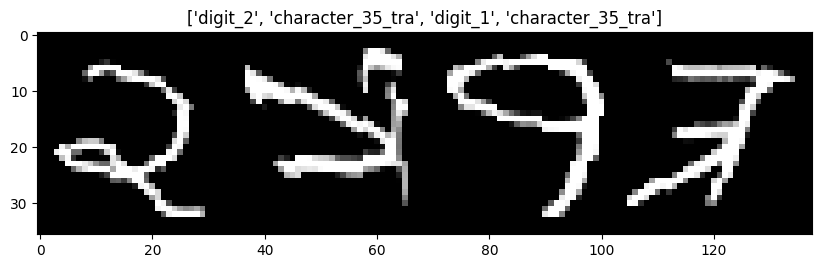

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # Convert from (Channels, Height, Width) to (Height, Width, Channels) this is pytorch style
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs[:4]) # 4 images
plt.figure(figsize=(10, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


class Basnet(nn.Module):
    def __init__(self, num_classes=46):
        super().__init__()

        # ---- Stem ----
        self.stem = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        # ---- Residual Stages ----
        self.stage1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)      # 32 → 16
        )

        self.stage2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            nn.MaxPool2d(2)      # 16 → 8
        )

        self.stage3 = nn.Sequential(
            ResidualBlock(128, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(2)      # 8 → 4
        )

        self.stage4 = nn.Sequential(
            ResidualBlock(256, 512),
            nn.MaxPool2d(2)      # 4 → 2
        )

        # ---- Classifier ----
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.classifier(x)
        return x


In [10]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

model = Basnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
print(device)
print(model)

mps
Basnet(
  (stem): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (stage1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2)

In [11]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")


Total trainable parameters: 9102842


In [12]:
class EarlyStopping:
  def __init__(self,patience=7, delta=0):
    self.patience = patience
    self.delta = delta
    self.counter = 0
    self.best_score = None
    self.early_stop = False

  def __call__(self,val_loss):
    if self.best_score is None:
      self.best_score = val_loss
    elif val_loss > self.best_score + self.delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True
    else:
      self.best_score = val_loss
      self.counter = 0

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    stopper = EarlyStopping(patience=5)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        print("-" * 20)

        model.train()
        running_loss = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        #validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val ACC: {val_acc:.4f}")

        stopper(avg_val_loss)
        if stopper.early_stop:
            print("Early stopping")
            break

    return model, history


In [15]:
model,history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50)

Epoch 1/50
--------------------


100%|██████████| 1222/1222 [03:10<00:00,  6.42it/s]


Train Loss: 0.3673 | Val Loss: 0.0697 | Val ACC: 0.9801
Epoch 2/50
--------------------


100%|██████████| 1222/1222 [03:15<00:00,  6.26it/s]


Train Loss: 0.1205 | Val Loss: 0.0706 | Val ACC: 0.9778
Epoch 3/50
--------------------


100%|██████████| 1222/1222 [03:56<00:00,  5.16it/s]


Train Loss: 0.1066 | Val Loss: 0.0556 | Val ACC: 0.9830
Epoch 4/50
--------------------


100%|██████████| 1222/1222 [03:49<00:00,  5.33it/s]


Train Loss: 0.0966 | Val Loss: 0.0484 | Val ACC: 0.9846
Epoch 5/50
--------------------


100%|██████████| 1222/1222 [03:55<00:00,  5.19it/s]


Train Loss: 0.0906 | Val Loss: 0.0505 | Val ACC: 0.9849
Epoch 6/50
--------------------


100%|██████████| 1222/1222 [04:00<00:00,  5.08it/s]


Train Loss: 0.0855 | Val Loss: 0.0485 | Val ACC: 0.9848
Epoch 7/50
--------------------


100%|██████████| 1222/1222 [04:04<00:00,  5.00it/s]


Train Loss: 0.0784 | Val Loss: 0.0435 | Val ACC: 0.9867
Epoch 8/50
--------------------


100%|██████████| 1222/1222 [04:03<00:00,  5.02it/s]


Train Loss: 0.0343 | Val Loss: 0.0170 | Val ACC: 0.9946
Epoch 9/50
--------------------


100%|██████████| 1222/1222 [04:05<00:00,  4.98it/s]


Train Loss: 0.0232 | Val Loss: 0.0153 | Val ACC: 0.9954
Epoch 10/50
--------------------


100%|██████████| 1222/1222 [04:16<00:00,  4.76it/s]


Train Loss: 0.0193 | Val Loss: 0.0157 | Val ACC: 0.9955
Epoch 11/50
--------------------


100%|██████████| 1222/1222 [04:12<00:00,  4.84it/s]


Train Loss: 0.0161 | Val Loss: 0.0141 | Val ACC: 0.9957
Epoch 12/50
--------------------


100%|██████████| 1222/1222 [04:08<00:00,  4.92it/s]


Train Loss: 0.0145 | Val Loss: 0.0156 | Val ACC: 0.9957
Epoch 13/50
--------------------


100%|██████████| 1222/1222 [04:12<00:00,  4.85it/s]


Train Loss: 0.0131 | Val Loss: 0.0163 | Val ACC: 0.9955
Epoch 14/50
--------------------


100%|██████████| 1222/1222 [03:53<00:00,  5.23it/s]


Train Loss: 0.0117 | Val Loss: 0.0164 | Val ACC: 0.9957
Epoch 15/50
--------------------


100%|██████████| 1222/1222 [04:06<00:00,  4.95it/s]


Train Loss: 0.0090 | Val Loss: 0.0134 | Val ACC: 0.9965
Epoch 16/50
--------------------


100%|██████████| 1222/1222 [04:07<00:00,  4.94it/s]


Train Loss: 0.0080 | Val Loss: 0.0131 | Val ACC: 0.9962
Epoch 17/50
--------------------


100%|██████████| 1222/1222 [04:11<00:00,  4.86it/s]


Train Loss: 0.0076 | Val Loss: 0.0135 | Val ACC: 0.9963
Epoch 18/50
--------------------


100%|██████████| 1222/1222 [04:02<00:00,  5.04it/s]


Train Loss: 0.0066 | Val Loss: 0.0127 | Val ACC: 0.9962
Epoch 19/50
--------------------


100%|██████████| 1222/1222 [04:04<00:00,  5.00it/s]


Train Loss: 0.0068 | Val Loss: 0.0134 | Val ACC: 0.9964
Epoch 20/50
--------------------


100%|██████████| 1222/1222 [04:13<00:00,  4.81it/s]


Train Loss: 0.0064 | Val Loss: 0.0135 | Val ACC: 0.9962
Epoch 21/50
--------------------


100%|██████████| 1222/1222 [04:02<00:00,  5.04it/s]


Train Loss: 0.0060 | Val Loss: 0.0131 | Val ACC: 0.9961
Epoch 22/50
--------------------


100%|██████████| 1222/1222 [04:00<00:00,  5.08it/s]


Train Loss: 0.0058 | Val Loss: 0.0130 | Val ACC: 0.9960
Epoch 23/50
--------------------


100%|██████████| 1222/1222 [04:08<00:00,  4.92it/s]


Train Loss: 0.0057 | Val Loss: 0.0127 | Val ACC: 0.9964
Epoch 24/50
--------------------


100%|██████████| 1222/1222 [04:17<00:00,  4.75it/s]


Train Loss: 0.0054 | Val Loss: 0.0128 | Val ACC: 0.9964
Epoch 25/50
--------------------


100%|██████████| 1222/1222 [04:00<00:00,  5.08it/s]


Train Loss: 0.0056 | Val Loss: 0.0127 | Val ACC: 0.9964
Epoch 26/50
--------------------


100%|██████████| 1222/1222 [04:10<00:00,  4.87it/s]


Train Loss: 0.0057 | Val Loss: 0.0130 | Val ACC: 0.9963
Epoch 27/50
--------------------


100%|██████████| 1222/1222 [04:15<00:00,  4.79it/s]


Train Loss: 0.0057 | Val Loss: 0.0132 | Val ACC: 0.9962
Epoch 28/50
--------------------


100%|██████████| 1222/1222 [04:05<00:00,  4.97it/s]


Train Loss: 0.0052 | Val Loss: 0.0133 | Val ACC: 0.9962
Epoch 29/50
--------------------


100%|██████████| 1222/1222 [04:10<00:00,  4.88it/s]


Train Loss: 0.0054 | Val Loss: 0.0126 | Val ACC: 0.9965
Epoch 30/50
--------------------


100%|██████████| 1222/1222 [04:02<00:00,  5.04it/s]


Train Loss: 0.0052 | Val Loss: 0.0128 | Val ACC: 0.9962
Epoch 31/50
--------------------


100%|██████████| 1222/1222 [04:03<00:00,  5.01it/s]


Train Loss: 0.0055 | Val Loss: 0.0130 | Val ACC: 0.9965
Epoch 32/50
--------------------


100%|██████████| 1222/1222 [04:02<00:00,  5.03it/s]


Train Loss: 0.0054 | Val Loss: 0.0135 | Val ACC: 0.9962
Epoch 33/50
--------------------


100%|██████████| 1222/1222 [04:02<00:00,  5.05it/s]


Train Loss: 0.0054 | Val Loss: 0.0128 | Val ACC: 0.9962
Epoch 34/50
--------------------


100%|██████████| 1222/1222 [04:12<00:00,  4.84it/s]


Train Loss: 0.0055 | Val Loss: 0.0128 | Val ACC: 0.9964
Early stopping


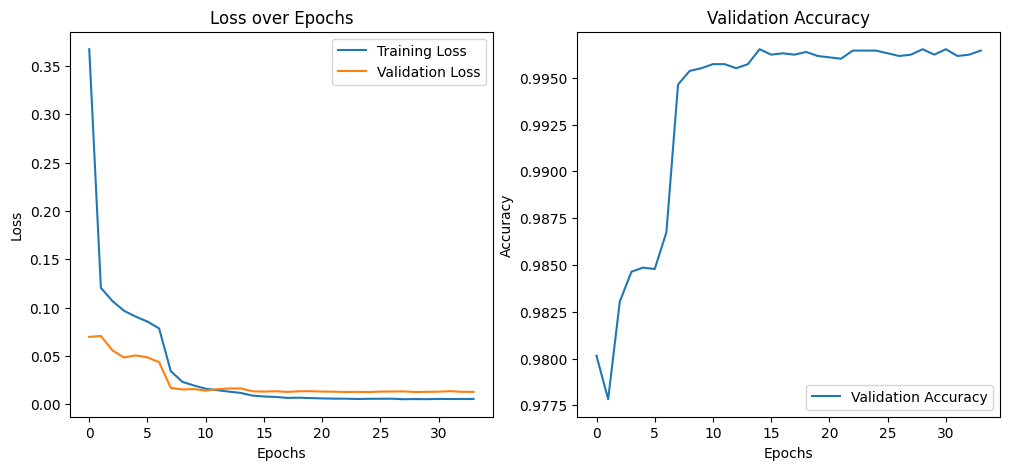

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()  

In [17]:
torch.save(model.state_dict(), "Basnet_V1.pth")